In [1]:
import re
import h5py
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from structures_store import h5_load_structure

In [2]:
# uniprot with interfaces
df = pd.read_csv("datasets/curated_interfaces_with_uniprot_human.csv").fillna("")

# variants data
dfv = pd.read_csv("datasets/variant_summary.txt", sep='\t')

In [3]:
# global parameters
mpi_thr_l = [0.5, 0.8]

## 1. Mutations

In [4]:
# parameters
sel_ftypes = ['mutagenesis site']

p_mut_l = []
for mpi_thr in mpi_thr_l:
    print("mpi_thr = {:.2f}".format(mpi_thr))
    
    # select by feature type
    dfs = df[df['ftype'].isin(sel_ftypes)]

    # select high quality predictions
    dfs = dfs[(dfs['mpi'] > mpi_thr) | (dfs['mpi'] < 0)]

    # display
    display(dfs['itype'].value_counts())
    display(dfs['itype'].value_counts(normalize=True))
    print("overlap probability: {:.1f}%".format(1e2*(1.0 - dfs['itype'].value_counts(normalize=True)[''])))
    p_mut_l.append(1e2*(1.0 - dfs['itype'].value_counts(normalize=True)['']))

mpi_thr = 0.50


           4648
ligand     2814
ion        2036
protein    1621
lipid      1014
dna/rna     611
Name: itype, dtype: int64

           0.364721
ligand     0.220810
ion        0.159761
protein    0.127197
lipid      0.079567
dna/rna    0.047944
Name: itype, dtype: float64

overlap probability: 63.5%
mpi_thr = 0.80


           4648
ion        1053
ligand     1034
protein    1007
lipid       651
dna/rna     344
Name: itype, dtype: int64

           0.531990
ion        0.120522
ligand     0.118347
protein    0.115257
lipid      0.074511
dna/rna    0.039373
Name: itype, dtype: float64

overlap probability: 46.8%


## 2 Sequence variant with ClinVar from dbSNP

In [5]:
# parameters
sel_ftypes = ['sequence variant']

p_pathogenic_l = []
p_benign_l = []
for mpi_thr in mpi_thr_l:
    print("mpi_thr = {:.2f}".format(mpi_thr))
    
    # select by feature type
    dfs = df[df['ftype'].isin(sel_ftypes)]

    # select high quality predictions
    dfs = dfs[(dfs['mpi'] > mpi_thr) | (dfs['mpi'] < 0)]

    # extract clinvars
    descs = dfs['desc'].values
    clinvars_l = []
    for desc in tqdm(descs):
        var_ids = [int(i) for i in re.findall(r"dbSNP:rs([0-9]*)", desc)]

        clinvars_all = []
        for var_id in var_ids:
            clinvars = dfv[dfv['RS# (dbSNP)'] == var_id]['ClinicalSignificance']
            for clinvar in clinvars:
                clinvars_all.append(clinvar)

        clinvars_l.append(';'.join(np.unique(clinvars_all)))

    # pack into dataframe
    dfs['clinvar'] = clinvars_l

    # PATHOGENIC
    key_words = [
        'Likely pathogenic', 'Likely pathogenic, Affects',
        'Likely pathogenic, other', 'Likely pathogenic, risk factor',
        'Pathogenic', 'Pathogenic, Affects', 'Pathogenic, drug response',
        'Pathogenic, other', 'Pathogenic, risk factor',
        'Pathogenic/Likely pathogenic',
        'Pathogenic/Likely pathogenic, drug response',
        'Pathogenic/Likely pathogenic, other',
        'Pathogenic/Likely pathogenic, risk factor'
    ]

    m = np.array([np.any(np.isin(key_words, v.split(';'))) for v in dfs['clinvar'].values])
    #m = np.any(np.stack([(dfs['clinvar'].values == kw) for kw in key_words], axis=1), axis=1)
    dfs0 = dfs[m]

    display(dfs0['itype'].value_counts())
    display(dfs0['itype'].value_counts(normalize=True))
    print("overlap probability: {:.1f}%".format(1e2*(1.0 - dfs0['itype'].value_counts(normalize=True)[''])))
    p_pathogenic_l.append(1e2*(1.0 - dfs0['itype'].value_counts(normalize=True)['']))

    # BENIGN
    key_words = [
        'Benign', 'Benign, confers sensitivity', 'Benign, other',
        'Benign, risk factor', 'Benign/Likely benign',
        'Benign/Likely benign, other', 'Benign/Likely benign, risk factor',
        'Likely benign', 'Likely benign, drug response, other',
        'Likely benign, other'
    ]

    m = np.array([np.any(np.isin(key_words, v.split(';'))) for v in dfs['clinvar'].values])
    #m = np.any(np.stack([(dfs['clinvar'].values == kw) for kw in key_words], axis=1), axis=1)
    dfs0 = dfs[m]

    display(dfs0['itype'].value_counts())
    display(dfs0['itype'].value_counts(normalize=True))
    print("overlap probability: {:.1f}%".format(1e2*(1.0 - dfs0['itype'].value_counts(normalize=True)[''])))
    p_benign_l.append(1e2*(1.0 - dfs0['itype'].value_counts(normalize=True)['']))

mpi_thr = 0.50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32502/32502 [00:06<00:00, 4944.48it/s]


           2633
ligand      592
protein     502
lipid       425
ion         309
dna/rna      80
Name: itype, dtype: int64

           0.579828
ligand     0.130368
protein    0.110548
lipid      0.093592
ion        0.068047
dna/rna    0.017617
Name: itype, dtype: float64

overlap probability: 42.0%


           238
lipid       36
protein     22
ligand      16
ion          7
dna/rna      3
Name: itype, dtype: int64

           0.739130
lipid      0.111801
protein    0.068323
ligand     0.049689
ion        0.021739
dna/rna    0.009317
Name: itype, dtype: float64

overlap probability: 26.1%
mpi_thr = 0.80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24979/24979 [00:05<00:00, 4658.34it/s]


           2633
protein     331
lipid       282
ligand      262
ion          99
dna/rna      40
Name: itype, dtype: int64

           0.721963
protein    0.090760
lipid      0.077324
ligand     0.071840
ion        0.027146
dna/rna    0.010968
Name: itype, dtype: float64

overlap probability: 27.8%


           238
lipid       18
protein     14
ligand       4
ion          2
dna/rna      1
Name: itype, dtype: int64

           0.859206
lipid      0.064982
protein    0.050542
ligand     0.014440
ion        0.007220
dna/rna    0.003610
Name: itype, dtype: float64

overlap probability: 14.1%


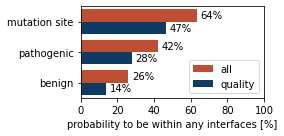

In [6]:
#from theme import colors
colors = ['#bf4e30', '#0d3b66', '#0e9595', '#dbad6a']
p_vals = np.array([p_benign_l, p_pathogenic_l, p_mut_l])

plt.figure(figsize=(4,2))
for i in range(p_vals.shape[1]):
    plt.barh(np.array([0,1,2])-0.4*i+0.2, p_vals[:,i], height=0.4, color=colors[i], label=['all','quality'][i])
    for k, v in enumerate(p_vals[:,i]):
        plt.text(v+8.0, k-0.4*i+0.2, '{:.0f}%'.format(v), horizontalalignment='center', verticalalignment='center')
plt.xlim(0.0, 100.0)
plt.ylim([-0.5, 2.5])
plt.legend(loc='best')
plt.yticks([0,1,2], ['benign','pathogenic','mutation site'])
plt.xlabel('probability to be within any interfaces [%]')
plt.tight_layout()
plt.savefig("results/overlapping_variants_both.png", dpi=300)
plt.savefig("results/overlapping_variants_both.svg")
plt.show()

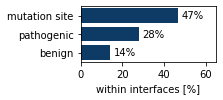

In [7]:
#from theme import colors
colors = ['#bf4e30', '#0d3b66', '#0e9595', '#dbad6a']
p_vals = np.array([p_benign_l, p_pathogenic_l, p_mut_l])[:,1]

plt.figure(figsize=(3.2,1.5))
plt.barh([0,1,2], p_vals, color=colors[1])
for k, v in enumerate(p_vals):
    plt.text(v+7.0, k, '{:.0f}%'.format(v), horizontalalignment='center', verticalalignment='center')
plt.xlim(0.0, 65.0)
plt.ylim([-0.5, 2.5])
plt.yticks([0,1,2], ['benign','pathogenic','mutation site'])
plt.xlabel('within interfaces [%]')
plt.tight_layout()
plt.savefig("results/overlapping_variants_quality.png", dpi=300)
plt.savefig("results/overlapping_variants_quality.svg")
plt.show()

In [8]:
# aggregated structures
structures = {}
with h5py.File("datasets/aggregated_structures_data.h5", 'r') as hf:
    #for uniprot in tqdm(hf.keys()):
    for uniprot in tqdm(df['uniprot'].unique()):
        structures[uniprot] = h5_load_structure(hf[uniprot])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7444/7444 [00:29<00:00, 248.27it/s]


In [9]:
# clustered interfaces
multi_interfaces_dict = json.load(open("datasets/clustered_multi_interfaces.json", 'r'))

In [10]:
# parameters
p_thr = 0.8
labels_map = {"protein":"p0", "dna/rna":"p1", "ion":"p2", "ligand":"p3", "lipid":"p4"}
itypes_sel = ["protein", "dna/rna", "ion", "ligand", "lipid"]

# select quality interfaces only
multi_interfaces_quality_dict = {}
for uniprot in tqdm(structures):
    multi_interfaces_quality_dict[uniprot] = {itype:[] for itype in multi_interfaces_dict[uniprot]}
    for itype in multi_interfaces_dict[uniprot]:
        if itype in itypes_sel:
            for ids_int in multi_interfaces_dict[uniprot][itype]:
                p = np.stack([structures[uniprot][labels_map[it]][ids_int] for it in itype.split('+')], axis=1)
                if np.all(np.mean(p, axis=0) > p_thr):
                    multi_interfaces_quality_dict[uniprot][itype].append(ids_int)
        else:
            multi_interfaces_quality_dict[uniprot][itype] = multi_interfaces_dict[uniprot][itype]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7444/7444 [00:01<00:00, 4748.33it/s]


In [11]:
sizes = []
for uniprot in df['uniprot'].unique():
    Ni = np.unique(np.concatenate([sum(multi_interfaces_quality_dict[uniprot][itype],[]) for itype in multi_interfaces_quality_dict[uniprot]]).astype(int)).shape[0]
    Na = structures[uniprot]['resid'].shape[0]
    sizes.append([Ni, Na])
    
sizes = np.array(sizes)

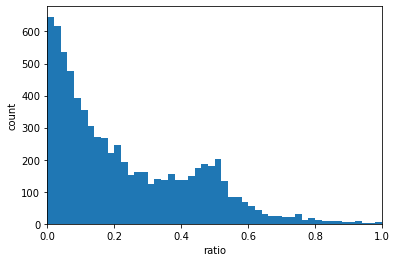

0.23 +- 0.20


In [12]:
r = sizes[:,0] / sizes[:,1]

plt.figure()
plt.hist(r, bins=50, range=(0,1))
plt.xlim(0.0, 1.0)
plt.xlabel('ratio')
plt.ylabel('count')
plt.show()

print("{:.2f} +- {:.2f}".format(np.mean(r), np.std(r)))

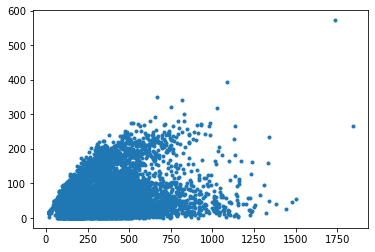

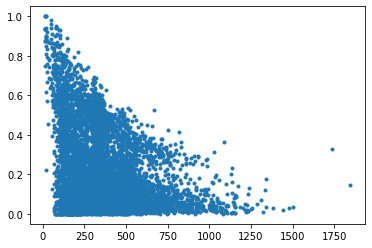

In [13]:
plt.figure()
plt.plot(sizes[:,1], sizes[:,0], '.')
plt.show()

plt.figure()
plt.plot(sizes[:,1], r, '.')
plt.show()

In [14]:
Ni, Na = np.sum(sizes, axis=0)
p_random = (Ni / Na)*1e2
p_random

18.794002282807295

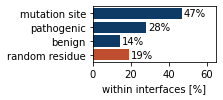

In [15]:
#from theme import colors
colors = ['#bf4e30', '#0d3b66', '#0e9595', '#dbad6a']
p_vals = np.array([p_benign_l[1], p_pathogenic_l[1], p_mut_l[1]])

plt.figure(figsize=(3.2,1.5))
plt.barh([0], [p_random], color=colors[0])
plt.text(p_random+7.0, 0, '{:.0f}%'.format(p_random), horizontalalignment='center', verticalalignment='center')
plt.barh([1,2,3], p_vals, color=colors[1])
for k, v in enumerate(p_vals):
    plt.text(v+7.0, k+1, '{:.0f}%'.format(v), horizontalalignment='center', verticalalignment='center')
plt.xlim(0.0, 65.0)
plt.ylim([-0.5, 3.5])
plt.yticks([0,1,2,3], ['random residue', 'benign','pathogenic','mutation site'])
plt.xlabel('within interfaces [%]')
plt.tight_layout()
plt.savefig("results/overlapping_variants_quality_baseline.png", dpi=300)
plt.savefig("results/overlapping_variants_quality_baseline.svg")
plt.show()